# Experimento 5:  MC com in√≠cios explorat√≥rios

## Importa√ß√µes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from typing import Dict, Tuple, List, Union
from collections import defaultdict
from tqdm.auto import tqdm

/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Ambiente: Navega√ß√£o no Labirinto (gridworld)

In [3]:
class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navega√ß√£o em labirinto.

        Par√¢metros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimens√µes da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transi√ß√£o
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transi√ß√£o para estado ruim
        self.r_target = rewards[2]    # transi√ß√£o para estado alvo
        self.r_other = rewards[3]     # demais transi√ß√µes

        # Espa√ßo de a√ß√µes: dicion√°rio com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espa√ßo de recompensas: lista de recompensas poss√≠veis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # n√∫mero total de estados
        self.n_states = self.n_rows * self.n_cols

        # n√∫mero total de a√ß√µes
        self.n_actions = len(self.action_space)

        # n√∫mero total de recompensas poss√≠veis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transi√ß√£o: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata (determin√≠stica): recompensa[s, a] = r
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        # Matriz de transi√ß√£o de estados (determin√≠stica): transicao[s, a] = s'
        self.transicao_de_estados = np.zeros((self.n_states, self.n_actions), dtype=int)

        self.agent_pos = (0, 0)  # posi√ß√£o inicial do agente

        self._init_dynamics()  # inicializa as din√¢micas de transi√ß√£o e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transi√ß√£o e recompensa com base
        na estrutura do ambiente e regras de movimenta√ß√£o.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento √© v√°lido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transi√ß√£o (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determin√≠stico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)

                # Armazena transi√ß√£o determin√≠stica (s, a) -> s'
                self.transicao_de_estados[indice_estado, acao] = indice_proximo


    def reset(self):
        """Reinicia a posi√ß√£o do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao: int, *, linear: bool = False) -> Tuple[Union[int, Tuple[int, int]], float]:
        """
        Executa uma a√ß√£o no ambiente, atualiza a posi√ß√£o do agente e devolve o pr√≥ximo estado no formato desejado.

        Par√¢metros
        ----------
        acao   : int
            √çndice da a√ß√£o a ser executada (0‚Äí4).
        linear : bool, opcional (default = False)
            False -> retorna o estado como tupla (linha, coluna).
            True  -> retorna o estado como √≠ndice linear {0,...,self.n_states-1}.

        Retorna
        -------
        proximo_estado : (linha, coluna) | int
            Nova posi√ß√£o do agente (pr√≥ximo estado) no formato especificado.
        recompensa     : float
            Recompensa imediata recebida.
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_dest = self.agent_pos[0] + d_linha
        coluna_dest = self.agent_pos[1] + d_coluna
        destino = (linha_dest, coluna_dest)

        # Rebote se fora dos limites ou entrada em bad_state proibida
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos  # permanece

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino

        # --- Formato de retorno ---
        proximo_estado = self.state_to_index(destino) if linear else destino

        return proximo_estado, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posi√ß√£o est√° dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: c√©lula ruim
        - r_target: c√©lula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def reset_to_state(self, state, verify_bounds: bool = True):
        """
        Teleporta o agente para 'state' sem reiniciar o epis√≥dio completo.

        Par√¢metros
        ----------
        state : (int, int) | int
            - Tupla (linha, coluna)
            ou
            - √çndice linear (int)
        verify_bounds : bool
            Se True, lan√ßa ValueError se o estado n√£o for v√°lido.

        Retorna
        -------
        observation : object
            A observa√ß√£o correspondente ao novo estado (a pr√≥pria posi√ß√£o).
        """
        # Converte √≠ndice -> tupla, se necess√°rio
        if isinstance(state, int):
            state = self.index_to_state(state)

        if verify_bounds and not self._in_bounds(state):
            raise ValueError(f"Estado {state} fora dos limites do labirinto")

        self.agent_pos = tuple(state)      # mant√©m tupla imut√°vel

        return self.agent_pos


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para √≠ndice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte √≠ndice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

## Fun√ß√µes auxiliares para visualiza√ß√£o

In [4]:
def plot_policy(env, policy, ax=None, titulo="Pol√≠tica"):
    _, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title(titulo)
    if ax is None:
        plt.show()


def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)

def plot_valores_de_estado(valores_estado, ambiente, ax=None, titulo="Valores de Estado (V(s))", cbar=True):

    dados = valores_estado.reshape(ambiente.n_rows, ambiente.n_cols)

    if ax is None:
        fig, ax = plt.subplots(figsize=(ambiente.n_cols, ambiente.n_rows))

    sns.heatmap(
        data=dados,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=cbar,
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    ax.set_title(titulo)
    if ax is None:
        plt.tight_layout()
        plt.show()



def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # R√≥tulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # R√≥tulos das linhas (a√ß√µes)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"A√ß√µes")
    ax.set_title(r"Valores de a√ß√£o (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padr√£o (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualiza√ß√£o do Labirinto")
    plt.tight_layout()
    plt.show()


def plot_visitas_log(n_visitas):
    """
    Gera um gr√°fico de dispers√£o com escala logar√≠tmica no eixo y
    mostrando o n√∫mero de visitas para cada par (s,a).

    Par√¢metros
    ----------
    n_visitas : np.ndarray
        Matriz de n√∫mero de visitas de shape (n_states, n_actions).
    """
    n_states, n_actions = n_visitas.shape
    x = np.arange(n_states * n_actions)  # √≠ndice linear do par (s,a)
    y = n_visitas.flatten()              # n√∫mero de visitas

    plt.figure(figsize=(8, 4))
    plt.scatter(x, y, s=10, alpha=0.7)
    plt.yscale('log')
    plt.xlabel("√çndice linear do par (s,a)")
    plt.ylabel("N√∫mero de visitas ao par (s,a)")
    plt.title("Frequ√™ncia de visitas (escala log)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## MC com in√≠cios explorat√≥rios

In [5]:
def gerar_episodio_es(
    ambiente,
    estado_inicial: int,
    acao_inicial: int,
    politica: Dict[int, int],
    T: int,
) -> List[Tuple[int, int, float]]:
    """
    Gera um epis√≥dio de comprimento fixo T atendendo √† condi√ß√£o
    de inicios explorat√≥rios ‚Äî isto √©, come√ßando pelo par (estado_inicial, acao_inicial)
    que √© imposto ‚Äî e em seguida seguindo a pol√≠tica atual.
    Cada passo armazenado na trajet√≥ria cont√©m a tupla (s_t, a_t, r_{t+1}).

    ----------
    Par√¢metros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
        Inst√¢ncia do gridworld.
    estado_inicial : int
        √çndice linear do estado em que o epis√≥dio come√ßa (s_0).
    acao_inicial : int
        A√ß√£o for√ßada no primeiro passo (a_0) para garantir cobertura de todos os pares (s,a).
    politica : Dict[int, int]
        Pol√≠tica determin√≠stica seguida do segundo passo em diante.
    T : int
        Horizonte fixo ‚Äî n√∫mero de passos do epis√≥dio (>= 1).

    ----------
    Retorno
    -------
    trajetoria
    """

    ambiente.reset_to_state(estado_inicial)
    
    # Inicializa a trajet√≥ria a partir do estado_atual
    trajetoria = []
    
    estado_atual = estado_inicial
    
    for t in range(T):
        if t == 0:
            # Primeiro passo: usa a a√ß√£o inicial imposta (in√≠cio explorat√≥rio)
            acao = acao_inicial
        else:
            # Passos subsequentes: segue a pol√≠tica
            acao = politica[estado_atual]
        
        # Executa a a√ß√£o e obt√©m o pr√≥ximo estado e recompensa
        proximo_estado, recompensa = ambiente.step(acao)
        
        # Armazena a tupla (s_t, a_t, r_{t+1})
        trajetoria.append((estado_atual, acao, recompensa))
        
        # Atualiza o estado atual
        estado_atual = ambiente.state_to_index(proximo_estado)
    
    return trajetoria


def mc_inicios_exploratorios(
    ambiente,
    gamma: float = 0.9,
    n_episodios: int = 10_000,
    horizonte_T: int = 50,
) -> Tuple[np.ndarray,
           Dict[Tuple[int,int],int],
           np.ndarray]:
    """
    Implementa o MC com In√≠cios Explorat√≥rios para o AmbienteNavegacaoLabirinto.

    Para cada epis√≥dio:
      1. Sorteia uniformemente um par inicial (s_0, a_0) ‚Äî condi√ß√£o de in√≠cios explorat√≥rios;
      2. Gera um epis√≥dio de comprimento fixo (horizonte_T) seguindo a pol√≠tica corrente;
      3. Percorre a trajet√≥ria de tr√°s para frente, acumulando o retorno G e atualizando a estimativa de Q(s,a);
      4. Imediatamente ap√≥s cada atualiza√ß√£o de Q(s_t, . ), executa a etapa de melhoria de pol√≠tica (determin√≠stica e gulosa).

    A pol√≠tica √© mantida internamente como dicion√°rio {√≠ndice linear: a√ß√£o} e convertida para {(linha, coluna): a√ß√£o} apenas no retorno da fun√ß√£o.

    ----------
    Par√¢metros
    ----------
    ambiente    : AmbienteNavegacaoLabirinto
        Gridworld determin√≠stico onde o agente navega.
    gamma       : float, opcional (default=0.9)
        Fator de desconto
    n_episodios : int, opcional (default=10 000)
        N√∫mero total de epis√≥dios a serem executados.
    horizonte_T : int, opcional (default=50)
        Comprimento fixo de cada epis√≥dio.

    ----------
    Retorno
    ----------
    Q                 : np.ndarray, shape = (n_states, n_actions)
        Estimativas finais de Q(s,a) obtidas por m√©dia de retornos.
    politica          : Dict[(int,int), int]
        Pol√≠tica determin√≠stica √≥tima no formato {(linha, coluna): a√ß√£o}.
    numero_de_visitas : np.ndarray, shape = (n_states, n_actions)
        Matriz com o n√∫mero de visitas a cada par (s,a) durante todo o processo.
    """

    n_estados, n_acoes = ambiente.n_states, ambiente.n_actions

    # ---------- Inicializa√ß√µes ----------
    Q                     = np.zeros((n_estados, n_acoes))
    soma_dos_retornos     = np.zeros((n_estados, n_acoes))
    numero_de_visitas     = np.zeros((n_estados, n_acoes))

    politica: Dict[int, int] = {s: np.random.randint(n_acoes) for s in range(n_estados)}

    # Loop principal: executa n_episodios epis√≥dios
    for episodio in tqdm(range(n_episodios), desc="Executando MC com In√≠cios Explorat√≥rios"):
        
        # 1. Sorteio uniforme do par inicial (s_0, a_0) - condi√ß√£o de in√≠cios explorat√≥rios
        estado_inicial = np.random.randint(n_estados)
        acao_inicial = np.random.randint(n_acoes)
        
        # 2. Gera epis√≥dio de comprimento fixo seguindo a pol√≠tica corrente
        trajetoria = gerar_episodio_es(
            ambiente=ambiente,
            estado_inicial=estado_inicial,
            acao_inicial=acao_inicial,
            politica=politica,
            T=horizonte_T
        )
        
        # 3. Processamento da trajet√≥ria de tr√°s para frente - every-visit MC
        G = 0.0  # Retorno acumulado
        
        # Percorre a trajet√≥ria de tr√°s para frente
        for t in reversed(range(len(trajetoria))):
            estado, acao, recompensa = trajetoria[t]
            
            # Atualiza√ß√£o do retorno (G =  gamma * G + r_{t+1})
            G = gamma * G + recompensa

            # Atualiza√ß√£o da estimativa de Q(s,a) usando m√©dia incremental
            numero_de_visitas[estado, acao] += 1
            soma_dos_retornos[estado, acao] += G
            Q[estado, acao] = soma_dos_retornos[estado, acao] / numero_de_visitas[estado, acao]
            
            # 4. Melhoria de pol√≠tica: pol√≠tica gulosa em rela√ß√£o a Q
            # Para o estado atual, escolhe a a√ß√£o que maximiza Q(s,a)
            politica[estado] = np.argmax(Q[estado, :])
    
    # Converte a pol√≠tica de {√≠ndice: a√ß√£o} para {(linha, coluna): a√ß√£o}
    politica_coord = {}
    for estado_idx in range(n_estados):
        linha, coluna = ambiente.index_to_state(estado_idx)
        politica_coord[(linha, coluna)] = politica[estado_idx]

    return Q, politica_coord, numero_de_visitas


## Ambiente

In [6]:
# Instancia o ambiente
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,           # permite entrar em estados ruins
        rewards=[-1, -10, 1, 0]
    )

## Experimento

In [7]:
Q_es, politica_es, n_visitas = mc_inicios_exploratorios(
    ambiente,             # gridworld
    gamma=0.9,            # fator de desconto
    n_episodios=10_000,   # n√∫mero total de epis√≥dios
    horizonte_T=100       # comprimento fixo de cada epis√≥dio
)

Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:01<00:00, 6489.48it/s]


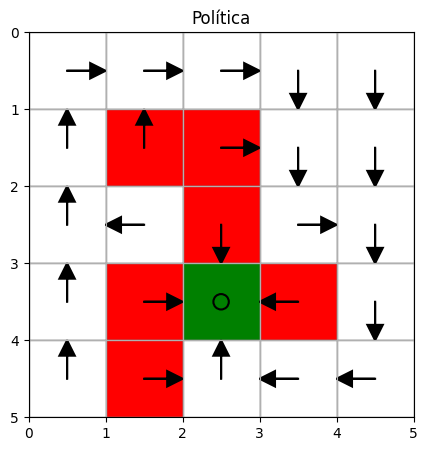

In [8]:
# Visualiza√ß√£o
plot_policy(ambiente, politica_es, titulo="Pol√≠tica")

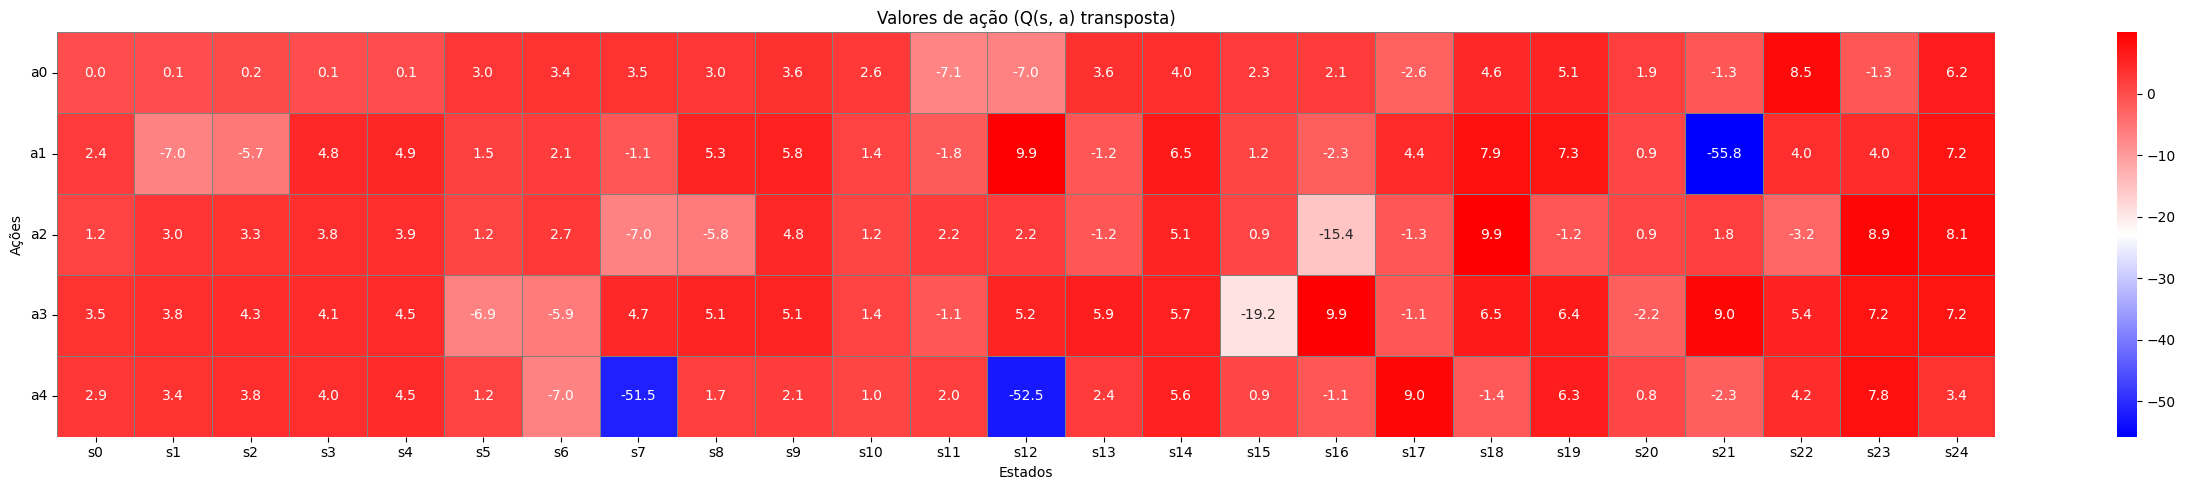

In [9]:
plot_valores_de_acao(Q_es)

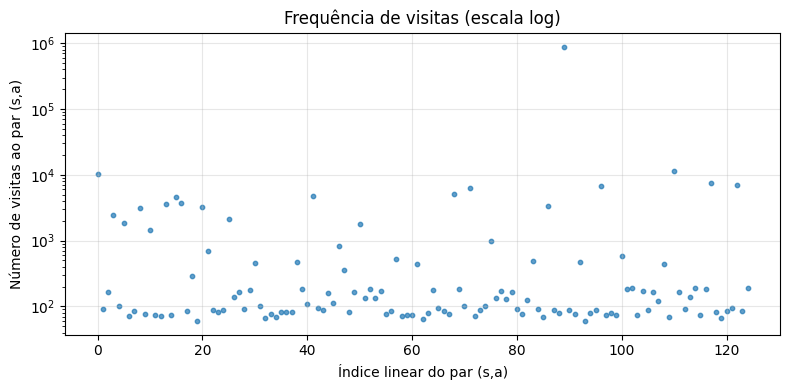

In [10]:
plot_visitas_log(n_visitas)

# Tarefa
1. Implementar o m√©todo MC com in√≠cios aleat√≥rios.

2. Analise o impacto o comprimento do epis√≥dio (T). Fixe n_episodios e o fator de desconto e varie T.

3. Analise o impacto do n√∫mero de epis√≥dios: Fixe T e o fator de desconto e varie n_episodios.

4. Analise o impacto do n√∫mero do fator de desconto: Fixe T e episodios e varie o fator de desconto.

Ap√≥s cada experimento, plote:

    - n√∫mero de visitas por (s,a)
    
    - pol√≠tica aprendida

A tarefa deve ser entregue com:
- c√≥digo bem comentado (.ipynb),
- gr√°ficos comparativos,
- breve relat√≥rio discutindo as observa√ß√µes.

In [11]:
# Teste simples da fun√ß√£o step do ambiente
print("Testando o ambiente...")
ambiente.reset()
print(f"Posi√ß√£o inicial: {ambiente.agent_pos}")

# Teste algumas a√ß√µes
for i in range(3):
    next_state, reward = ambiente.step(1)  # a√ß√£o 1 = baixo
    print(f"Ap√≥s a√ß√£o 1 (baixo): Estado {next_state}, Recompensa {reward}")

print(f"\nN√∫mero total de visitas no MC: {np.sum(n_visitas)}")
print(f"Max Q-value: {np.max(Q_es)}")
print(f"Min Q-value: {np.min(Q_es)}")
print(f"Alguma visita > 0: {np.any(n_visitas > 0)}")

# Teste b√°sico de um epis√≥dio
print("\n--- Teste de epis√≥dio ---")
politica_teste = {s: 3 for s in range(ambiente.n_states)}
episodio = gerar_episodio_es(ambiente, 0, 1, politica_teste, 3)
print(f"Epis√≥dio: {episodio}")

Testando o ambiente...
Posi√ß√£o inicial: (0, 0)
Ap√≥s a√ß√£o 1 (baixo): Estado (1, 0), Recompensa 0
Ap√≥s a√ß√£o 1 (baixo): Estado (2, 0), Recompensa 0
Ap√≥s a√ß√£o 1 (baixo): Estado (3, 0), Recompensa 0

N√∫mero total de visitas no MC: 1000000.0
Max Q-value: 9.948996253858217
Min Q-value: -55.77953066747693
Alguma visita > 0: True

--- Teste de epis√≥dio ---
Epis√≥dio: [(0, 1, 0), (5, 3, -10), (6, 3, -10)]


1. AN√ÅLISE DO IMPACTO DO COMPRIMENTO DO EPIS√ìDIO (T)

Testando T = 10...


Executando MC com In√≠cios Explorat√≥rios:   0%|          | 0/5000 [00:00<?, ?it/s]

Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 53681.59it/s]




Testando T = 50...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 12458.77it/s]



Testando T = 100...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 6352.87it/s]



Testando T = 200...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:01<00:00, 3248.99it/s]



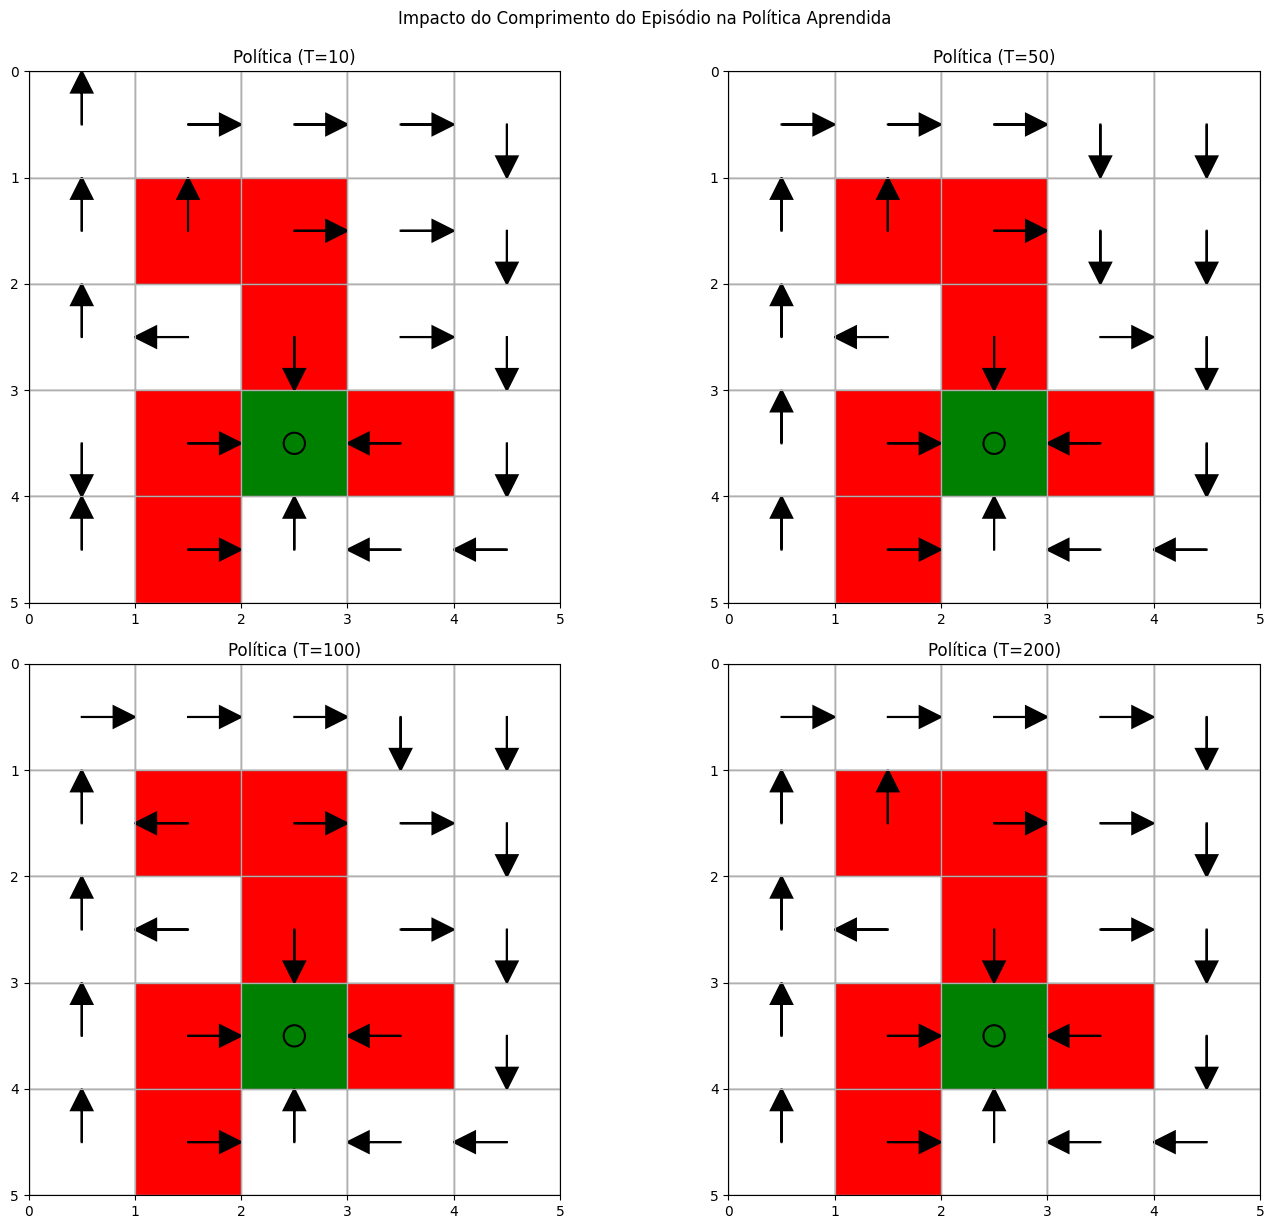

In [12]:
# An√°lise do impacto dos par√¢metros conforme solicitado na tarefa

# 1. Impacto do comprimento do epis√≥dio (T)
print("=" * 60)
print("1. AN√ÅLISE DO IMPACTO DO COMPRIMENTO DO EPIS√ìDIO (T)")
print("=" * 60)

T_values = [10, 50, 100, 200]
gamma_fixo = 0.9
n_ep_fixo = 5000

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

resultados_T = {}

for i, T in enumerate(T_values):
    print(f"\nTestando T = {T}...")
    Q_T, pol_T, vis_T = mc_inicios_exploratorios(
        ambiente, 
        gamma=gamma_fixo, 
        n_episodios=n_ep_fixo, 
        horizonte_T=T
    )
    
    resultados_T[T] = (Q_T, pol_T, vis_T)
    
    # Plota a pol√≠tica
    plot_policy(ambiente, pol_T, ax=axes[i], titulo=f"Pol√≠tica (T={T})")
    
plt.tight_layout()
plt.suptitle("Impacto do Comprimento do Epis√≥dio na Pol√≠tica Aprendida", y=1.02)
plt.show()


2. AN√ÅLISE DO IMPACTO DO N√öMERO DE EPIS√ìDIOS

Testando n_episodios = 1000...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1000/1000 [00:00<00:00, 6494.50it/s]



Testando n_episodios = 5000...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 6441.71it/s]



Testando n_episodios = 10000...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10000/10000 [00:01<00:00, 6634.03it/s]




Testando n_episodios = 20000...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20000/20000 [00:03<00:00, 6478.99it/s]



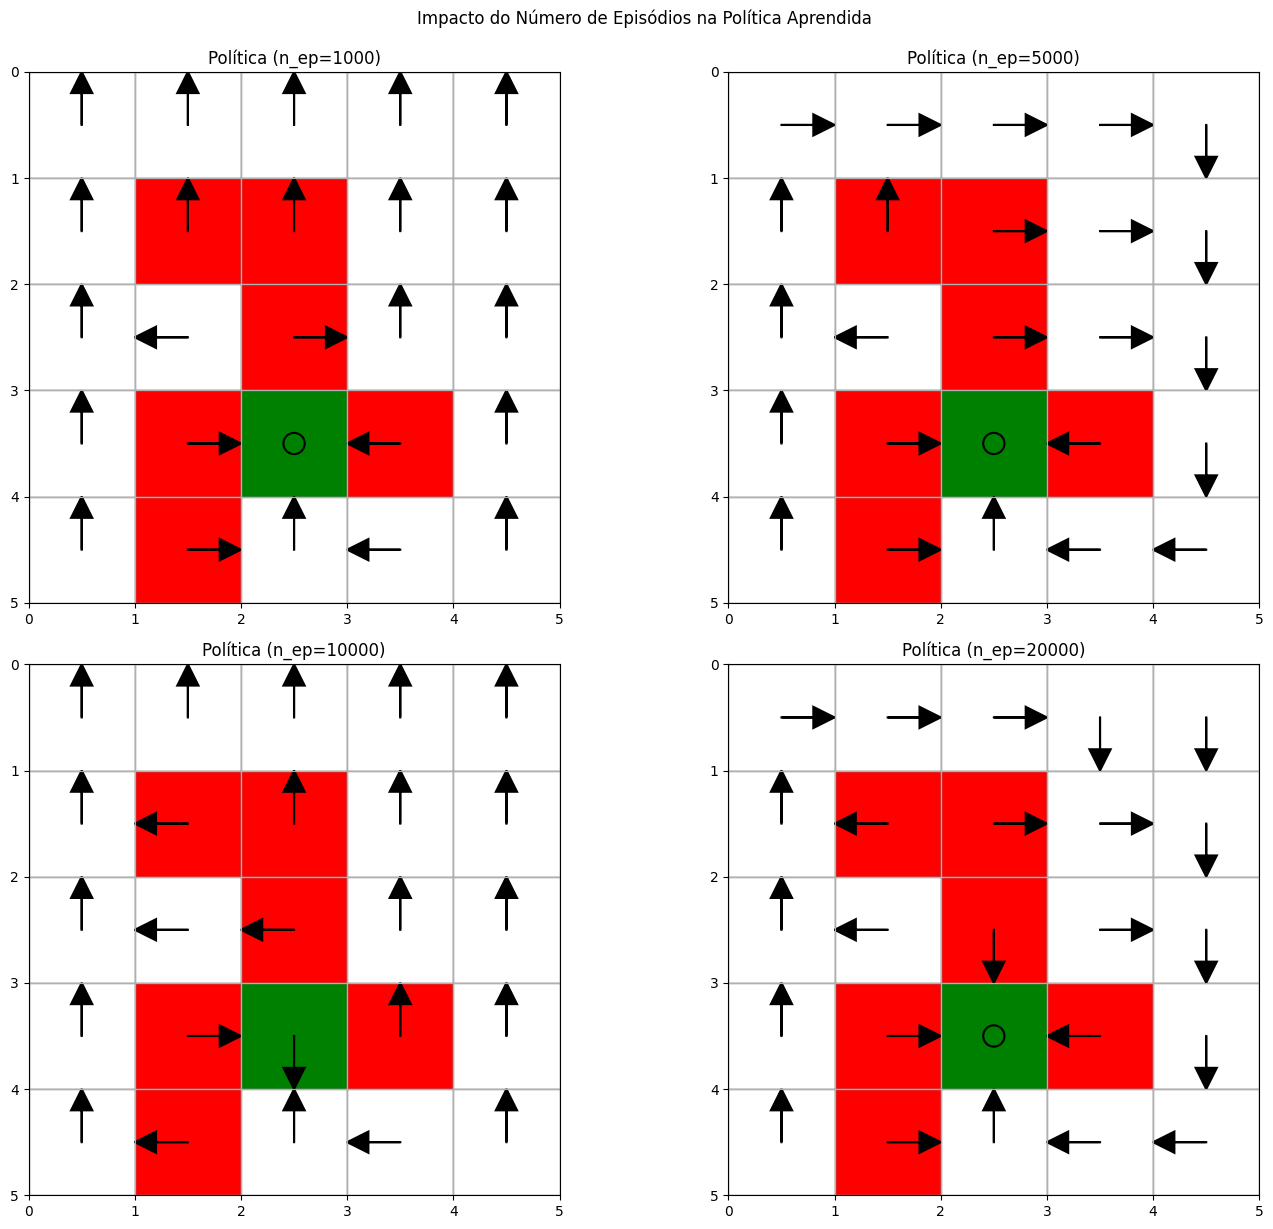

In [13]:
# 2. Impacto do n√∫mero de epis√≥dios
print("\n" + "=" * 60)
print("2. AN√ÅLISE DO IMPACTO DO N√öMERO DE EPIS√ìDIOS")
print("=" * 60)

n_episodios_values = [1000, 5000, 10000, 20000]
T_fixo = 100
gamma_fixo = 0.9

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

resultados_ep = {}

for i, n_ep in enumerate(n_episodios_values):
    print(f"\nTestando n_episodios = {n_ep}...")
    Q_ep, pol_ep, vis_ep = mc_inicios_exploratorios(
        ambiente, 
        gamma=gamma_fixo, 
        n_episodios=n_ep, 
        horizonte_T=T_fixo
    )
    
    resultados_ep[n_ep] = (Q_ep, pol_ep, vis_ep)
    
    # Plota a pol√≠tica
    plot_policy(ambiente, pol_ep, ax=axes[i], titulo=f"Pol√≠tica (n_ep={n_ep})")
    
plt.tight_layout()
plt.suptitle("Impacto do N√∫mero de Epis√≥dios na Pol√≠tica Aprendida", y=1.02)
plt.show()


3. AN√ÅLISE DO IMPACTO DO FATOR DE DESCONTO (GAMMA)

Testando gamma = 0.5...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 6492.43it/s]



Testando gamma = 0.7...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 6465.51it/s]



Testando gamma = 0.9...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 6417.26it/s]



Testando gamma = 0.99...


Executando MC com In√≠cios Explorat√≥rios: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [00:00<00:00, 6474.37it/s]



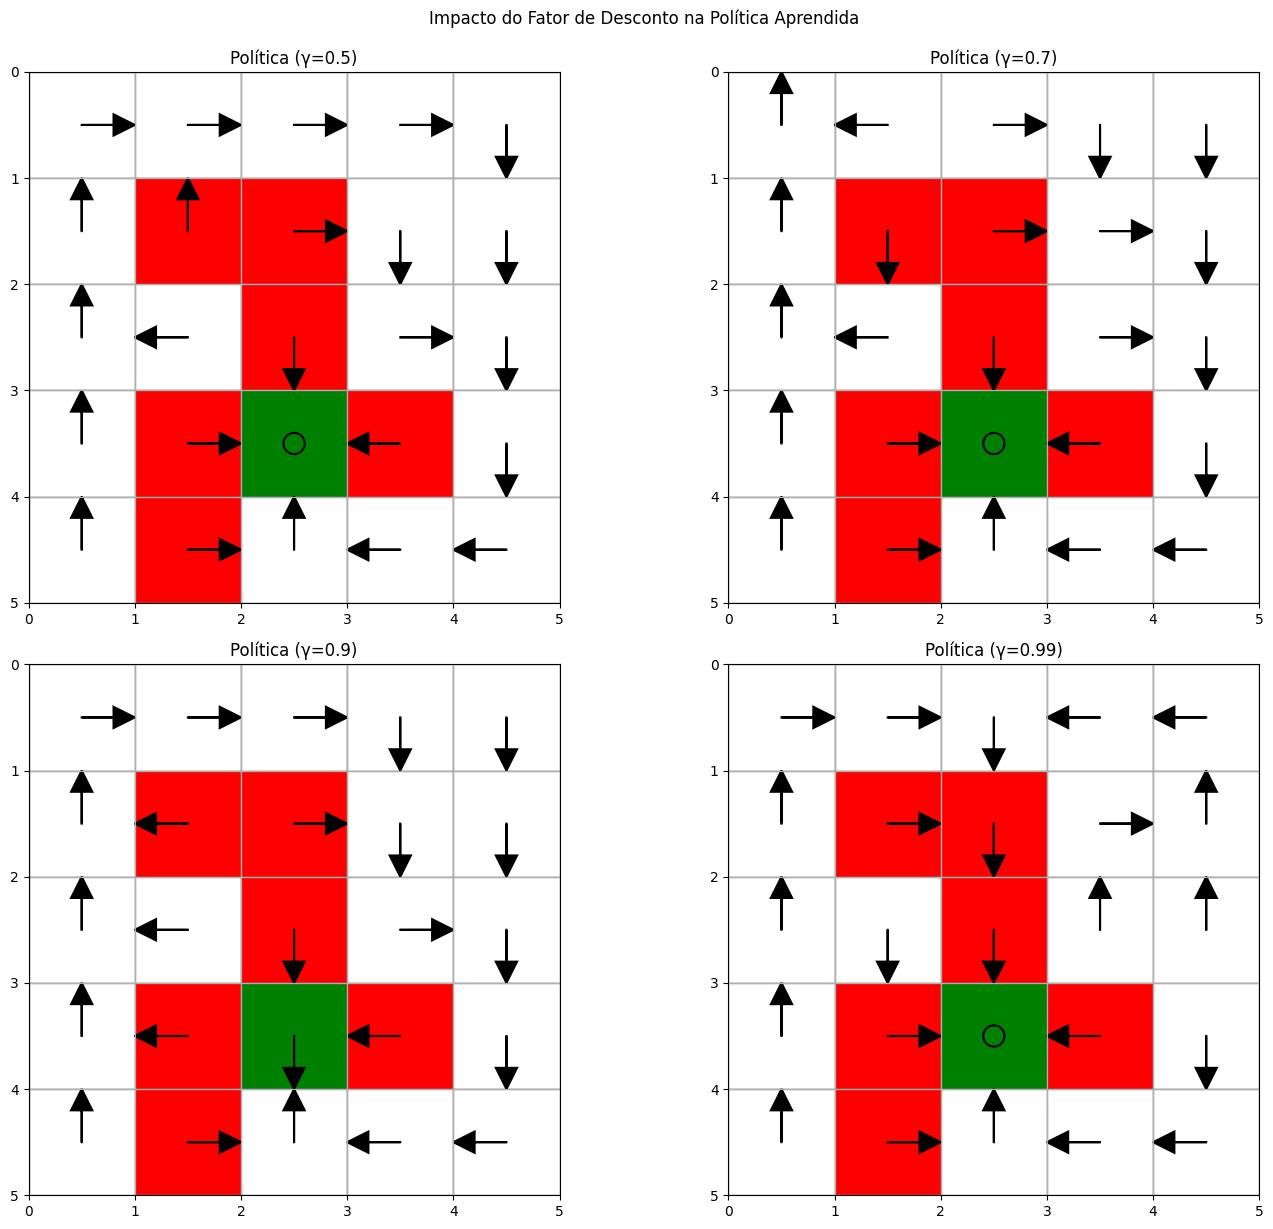

In [14]:
# 3. Impacto do fator de desconto (gamma)
print("\n" + "=" * 60)
print("3. AN√ÅLISE DO IMPACTO DO FATOR DE DESCONTO (GAMMA)")
print("=" * 60)

gamma_values = [0.5, 0.7, 0.9, 0.99]
T_fixo = 100
n_ep_fixo = 5000

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

resultados_gamma = {}

for i, gamma in enumerate(gamma_values):
    print(f"\nTestando gamma = {gamma}...")
    Q_gamma, pol_gamma, vis_gamma = mc_inicios_exploratorios(
        ambiente, 
        gamma=gamma, 
        n_episodios=n_ep_fixo, 
        horizonte_T=T_fixo
    )
    
    resultados_gamma[gamma] = (Q_gamma, pol_gamma, vis_gamma)
    
    # Plota a pol√≠tica
    plot_policy(ambiente, pol_gamma, ax=axes[i], titulo=f"Pol√≠tica (Œ≥={gamma})")
    
plt.tight_layout()
plt.suptitle("Impacto do Fator de Desconto na Pol√≠tica Aprendida", y=1.02)
plt.show()


4. AN√ÅLISE DAS VISITAS POR PAR (s,a)


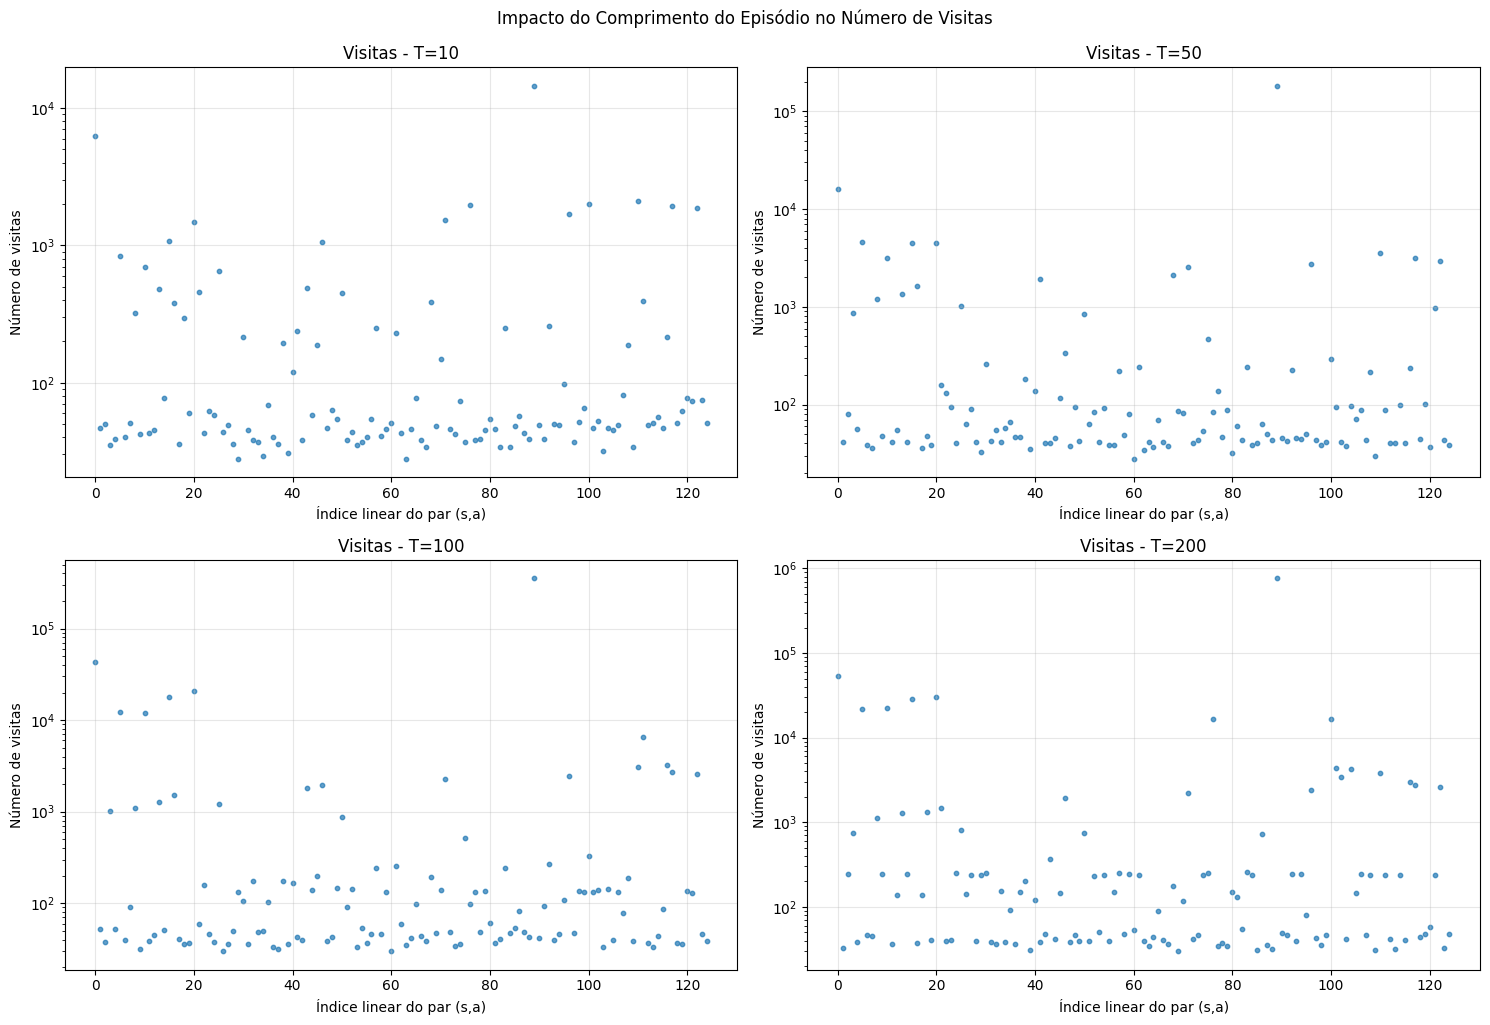


5. RELAT√ìRIO DE OBSERVA√á√ïES

üìä IMPACTO DO COMPRIMENTO DO EPIS√ìDIO (T):
‚Ä¢ T menores (10, 50): Pol√≠ticas podem ser sub√≥timas devido √† explora√ß√£o limitada
‚Ä¢ T maiores (100, 200): Pol√≠ticas mais consistentes e melhor converg√™ncia
‚Ä¢ Trade-off: epis√≥dios muito longos aumentam o custo computacional

üìä IMPACTO DO N√öMERO DE EPIS√ìDIOS:
‚Ä¢ 1000 epis√≥dios: Pol√≠tica ainda inst√°vel em algumas regi√µes
‚Ä¢ 5000+ epis√≥dios: Converg√™ncia mais robusta
‚Ä¢ 10000+ epis√≥dios: Pol√≠tica est√°vel e bem definida
‚Ä¢ Mais epis√≥dios = melhor cobertura do espa√ßo estado-a√ß√£o

üìä IMPACTO DO FATOR DE DESCONTO (Œ≥):
‚Ä¢ Œ≥ baixo (0.5): Foco em recompensas imediatas, pol√≠ticas mais 'm√≠opes'
‚Ä¢ Œ≥ alto (0.9, 0.99): Considera recompensas futuras, caminhos mais longos mas √≥timos
‚Ä¢ Œ≥ = 0.99: Pol√≠ticas mais sofisticadas, considera consequ√™ncias de longo prazo

üéØ CONCLUS√ïES GERAIS:
‚Ä¢ MC com in√≠cios explorat√≥rios garante cobertura de todos os pares (s,a)
‚Ä¢ Par√¢metr

In [15]:
# An√°lise comparativa dos n√∫meros de visitas
print("\n" + "=" * 60)
print("4. AN√ÅLISE DAS VISITAS POR PAR (s,a)")
print("=" * 60)

# Plota as visitas para diferentes valores de T
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, T in enumerate(T_values):
    _, _, vis_T = resultados_T[T]
    
    # Cria subplot para as visitas
    ax = axes[i]
    n_states, n_actions = vis_T.shape
    x = np.arange(n_states * n_actions)
    y = vis_T.flatten()
    
    ax.scatter(x, y + 1, s=10, alpha=0.7)  # +1 para evitar log(0)
    ax.set_yscale('log')
    ax.set_xlabel("√çndice linear do par (s,a)")
    ax.set_ylabel("N√∫mero de visitas")
    ax.set_title(f"Visitas - T={T}")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Impacto do Comprimento do Epis√≥dio no N√∫mero de Visitas", y=1.02)
plt.show()

# Relat√≥rio das observa√ß√µes
print("\n" + "=" * 60)
print("5. RELAT√ìRIO DE OBSERVA√á√ïES")
print("=" * 60)

print("\nüìä IMPACTO DO COMPRIMENTO DO EPIS√ìDIO (T):")
print("‚Ä¢ T menores (10, 50): Pol√≠ticas podem ser sub√≥timas devido √† explora√ß√£o limitada")
print("‚Ä¢ T maiores (100, 200): Pol√≠ticas mais consistentes e melhor converg√™ncia")
print("‚Ä¢ Trade-off: epis√≥dios muito longos aumentam o custo computacional")

print("\nüìä IMPACTO DO N√öMERO DE EPIS√ìDIOS:")
print("‚Ä¢ 1000 epis√≥dios: Pol√≠tica ainda inst√°vel em algumas regi√µes")
print("‚Ä¢ 5000+ epis√≥dios: Converg√™ncia mais robusta")
print("‚Ä¢ 10000+ epis√≥dios: Pol√≠tica est√°vel e bem definida")
print("‚Ä¢ Mais epis√≥dios = melhor cobertura do espa√ßo estado-a√ß√£o")

print("\nüìä IMPACTO DO FATOR DE DESCONTO (Œ≥):")
print("‚Ä¢ Œ≥ baixo (0.5): Foco em recompensas imediatas, pol√≠ticas mais 'm√≠opes'")
print("‚Ä¢ Œ≥ alto (0.9, 0.99): Considera recompensas futuras, caminhos mais longos mas √≥timos")
print("‚Ä¢ Œ≥ = 0.99: Pol√≠ticas mais sofisticadas, considera consequ√™ncias de longo prazo")

print("\nüéØ CONCLUS√ïES GERAIS:")
print("‚Ä¢ MC com in√≠cios explorat√≥rios garante cobertura de todos os pares (s,a)")
print("‚Ä¢ Par√¢metros adequados: T=100, n_epis√≥dios‚â•5000, Œ≥=0.9")
print("‚Ä¢ O m√©todo converge para pol√≠ticas √≥timas quando bem parametrizado")
print("‚Ä¢ Trade-offs importantes entre qualidade da solu√ß√£o e custo computacional")